Ingrese direcciones de memoria (q para terminar):
Dirección: 0
Dirección: 4
Dirección: 8
Dirección: 12
Dirección: 64
Dirección: q

Configuración A
Configuración de la caché
Ingrese CACHE_SIZE (ej: 2, 4, 8): 2
Ingrese BLOCK_SIZE en bytes (ej: 32, 64, 128): 16

Configuración B
Configuración de la caché
Ingrese CACHE_SIZE (ej: 2, 4, 8): 2
Ingrese BLOCK_SIZE en bytes (ej: 32, 64, 128): 64

--- Simulación detallada: Configuración A ---
CACHE_SIZE = 2 | BLOCK_SIZE = 16

Acceso 1 | Dir 0 | Bloque 0 | MISS | Lat 10 ciclos
  Caché actual: [0]

Acceso 2 | Dir 4 | Bloque 0 | HIT | Lat 1 ciclos
  Caché actual: [0]

Acceso 3 | Dir 8 | Bloque 0 | HIT | Lat 1 ciclos
  Caché actual: [0]

Acceso 4 | Dir 12 | Bloque 0 | HIT | Lat 1 ciclos
  Caché actual: [0]

Acceso 5 | Dir 64 | Bloque 4 | MISS | Lat 10 ciclos
  Caché actual: [0, 4]


--- Simulación detallada: Configuración B ---
CACHE_SIZE = 2 | BLOCK_SIZE = 64

Acceso 1 | Dir 0 | Bloque 0 | MISS | Lat 10 ciclos
  Caché actual: [0]

Acceso 2 | Dir 4 | 

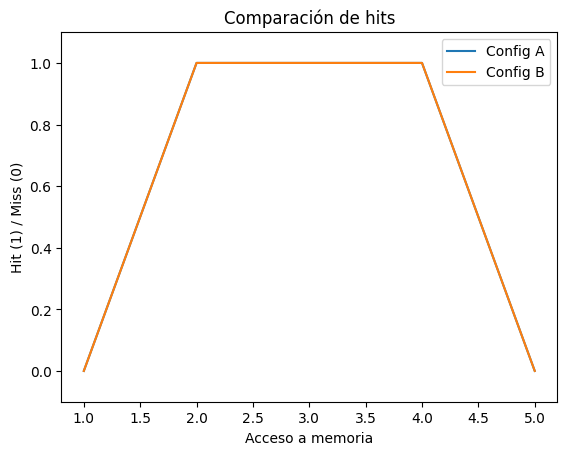

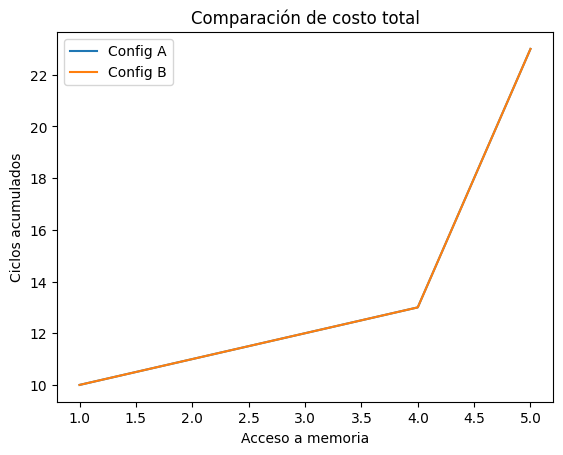

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

HIT_LATENCY=1
MISS_LATENCY=10

def simulate_memory_access(address, memory_blocks, cache_size, block_size):
    block = address // block_size
    replaced_block=None

    if block in memory_blocks:
        hit = 1
        latency = HIT_LATENCY
    else:
        hit = 0
        latency = MISS_LATENCY

        if len(memory_blocks) >= cache_size:
           replaced_block=memory_blocks.pop(0)  # sale el más viejo (FIFO)

        memory_blocks.append(block)

    return {
        "address": address,
        "block": block,
        "hit": hit,
        "latency_cycles": latency,
        "cache_state": memory_blocks.copy(),
        "replaced_block": replaced_block

    }

def choose_configuration():
    print("Configuración de la caché")

    cache_size = int(input("Ingrese CACHE_SIZE (ej: 2, 4, 8): "))
    block_size = int(input("Ingrese BLOCK_SIZE en bytes (ej: 32, 64, 128): "))

    return cache_size, block_size

def input_address_sequence():
    addresses = []

    print("Ingrese direcciones de memoria (q para terminar):")

    while True:
        user_input = input("Dirección: ")

        if user_input.lower() == "q":
            break

        try:
            addresses.append(int(user_input))
        except ValueError:
            print("Dirección inválida")

    return addresses

def run_simulation_verbose(addresses, cache_size, block_size, label):
    memory_blocks = []
    access_log = []

    print(f"\n--- Simulación detallada: {label} ---")
    print(f"CACHE_SIZE = {cache_size} | BLOCK_SIZE = {block_size}\n")

    for i, address in enumerate(addresses, start=1):
        result = simulate_memory_access(
            address, memory_blocks, cache_size, block_size
        )

        access_log.append(result)

        estado = "HIT" if result["hit"] else "MISS"

        print(
            f"Acceso {i} | Dir {address} | Bloque {result['block']} | {estado} | "
            f"Lat {result['latency_cycles']} ciclos"
        )

        if result["replaced_block"] is not None:
            print(f"  ↳ Se expulsó el bloque {result['replaced_block']}")

        print(f"  Caché actual: {result['cache_state']}\n")

    return pd.DataFrame(access_log)


def analyze_results(df):
    if df.empty:
        print("No se ingresaron accesos.")
        return

    hit_rate = df["hit"].mean()
    avg_latency = df["latency_cycles"].mean()
    total_accesses = len(df)

    hits = df["hit"].sum()
    misses = total_accesses - hits

    print("\nResumen de la simulación")
    print("------------------------")
    print(f"Accesos totales: {total_accesses}")
    print(f"Hits: {hits}")
    print(f"Misses: {misses}")
    print(f"Hit rate: {hit_rate:.2f}")
    print(f"Latencia promedio: {avg_latency:.2f} ciclos")


# --- EJECUCIÓN ---
addresses = input_address_sequence()

print("\nConfiguración A")
cache_size_a, block_size_a = choose_configuration()

print("\nConfiguración B")
cache_size_b, block_size_b = choose_configuration()

df_a = run_simulation_verbose(
    addresses, cache_size_a, block_size_a, "Configuración A"
)

df_b = run_simulation_verbose(
    addresses, cache_size_b, block_size_b, "Configuración B"
)

print("\nResultados Configuración A")
analyze_results(df_a)

print("\nResultados Configuración B")
analyze_results(df_b)

df_a["access_number"] = range(1, len(df_a) + 1)
df_b["access_number"] = range(1, len(df_b) + 1)

df_a["latencia_acumulada"] = df_a["latency_cycles"].cumsum()
df_b["latencia_acumulada"] = df_b["latency_cycles"].cumsum()

# --- GRÁFICO DE HITS ---
plt.figure()
plt.plot(df_a["access_number"], df_a["hit"], label="Config A")
plt.plot(df_b["access_number"], df_b["hit"], label="Config B")
plt.xlabel("Acceso a memoria")
plt.ylabel("Hit (1) / Miss (0)")
plt.title("Comparación de hits")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

# --- GRÁFICO DE COSTO ---
plt.figure()
plt.plot(df_a["access_number"], df_a["latencia_acumulada"], label="Config A")
plt.plot(df_b["access_number"], df_b["latencia_acumulada"], label="Config B")
plt.xlabel("Acceso a memoria")
plt.ylabel("Ciclos acumulados")
plt.title("Comparación de costo total")
plt.legend()
plt.show()
